# Fashion Store Analysis

In this project I'll take a data set from a fashion store and see the fashion retail sales, I'll use this data and run a K means clustering algorithm to see if there is any underlying information that can be presented as a final report to a potential business owner/manager.

In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(repr)
library(janitor)
library(recipes)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
unscaled_data <- read_csv("Fashion_Retail_Sales.csv")

Rows: 3400 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Item Purchased, Payment Method
dbl  (3): Customer Reference ID, Purchase Amount (USD), Review Rating
date (1): Date Purchase

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
unscaled_data <-unscaled_data |> clean_names()
glimpse(unscaled_data)

Rows: 3,400
Columns: 6
$ customer_reference_id <dbl> 4018, 4115, 4019, 4097, 3997, 4080, 4055, 3973, …
$ item_purchased        <chr> "Handbag", "Tunic", "Tank Top", "Leggings", "Wal…
$ purchase_amount_usd   <dbl> 4619, 2456, 2102, 3126, 3003, 2914, 2571, 2419, …
$ date_purchase         <date> 2023-02-05, 2023-07-11, 2023-03-23, 2023-03-15,…
$ review_rating         <dbl> NA, 2.0, 4.1, 3.2, 4.7, 4.5, 1.3, 4.6, 4.1, NA, …
$ payment_method        <chr> "Credit Card", "Credit Card", "Cash", "Cash", "C…


First, I'll find the max date in the `date_purchase` column, this date is the most recent date of transaction by a customer.

In [4]:
max_date <- max(unscaled_data$date_purchase, na.rm = TRUE)
max_date

[1] "2023-10-01"

Next I'll aggregate the data by grouping by `customer_reference_id` to see all individual customers and then making a new data frame to see: 
- `frequency`(the number of times that customer has came and bought something in the store)
- `total_spent` (which is the total amount spent at the store by that customer)
- `recency` (which is the number of days since the last purchase until the most recent date of transaction)

In [5]:
agg_data <- unscaled_data |>
    group_by(customer_reference_id) |>
    summarise(frequency = as.numeric(n()),
             total_spent = as.numeric(sum(purchase_amount_usd, na.rm = TRUE)),
             recency = as.numeric(max_date - max(date_purchase, na.rm = TRUE)))

agg_data

customer_reference_id,frequency,total_spent,recency
<dbl>,<dbl>,<dbl>,<dbl>
3957,14,1150,85
3958,20,1334,17
3959,22,2047,28
3960,18,1434,17
3961,22,1811,33
3962,22,1617,6
3963,20,1592,4
3964,22,1841,7
3965,19,1918,3


## Kmeans

First I will remove `customer_reference_id` so we can focus on the three other predictors. I will also remove any NA values.

In [6]:
selected_set <- agg_data |>
    select(-customer_reference_id) |>
    drop_na()

selected_set

frequency,total_spent,recency
<dbl>,<dbl>,<dbl>
14,1150,85
20,1334,17
22,2047,28
18,1434,17
22,1811,33
22,1617,6
20,1592,4
22,1841,7
19,1918,3


This will be the recipe that I will use throughout the clustering algorithm.

In [7]:
kmeans_recipe <- recipe(~ ., data = selected_set) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
kmeans_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

predictor: 3



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



#### Find appropriate $K$

In [8]:
clust_ks <- tibble(num_clusters = 1:10)
clust_ks

num_clusters
<int>
1
2
3
4
5
6
7
8
9


In [9]:
kmeans_spec <- k_means(num_clusters = tune()) |>
    set_engine("stats", nstart = 10)

kmeans_spec

K Means Cluster Specification (partition)

Main Arguments:
  num_clusters = tune()

Engine-Specific Arguments:
  nstart = 10

Computational engine: stats 


In [10]:
kmeans_results <- workflow() |>
    add_recipe(kmeans_recipe) |>
    add_model(kmeans_spec) |>
    tune_cluster(resamples = apparent(selected_set), grid = clust_ks) |>
    collect_metrics()
kmeans_results

num_clusters,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,sse_total,standard,495.00000,1,NA,Preprocessor1_Model01
1,sse_within_total,standard,495.00000,1,NA,Preprocessor1_Model01
2,sse_total,standard,495.00000,1,NA,Preprocessor1_Model02
2,sse_within_total,standard,342.85093,1,NA,Preprocessor1_Model02
3,sse_total,standard,495.00000,1,NA,Preprocessor1_Model03
3,sse_within_total,standard,237.24354,1,NA,Preprocessor1_Model03
4,sse_total,standard,495.00000,1,NA,Preprocessor1_Model04
4,sse_within_total,standard,171.78767,1,NA,Preprocessor1_Model04
5,sse_total,standard,495.00000,1,NA,Preprocessor1_Model05


num_clusters,total_WSSD
<int>,<dbl>
1,495.00000
2,342.85093
3,237.24354
4,171.78767
5,148.11291
6,128.81110
7,109.98744
8,97.06275
9,87.04121


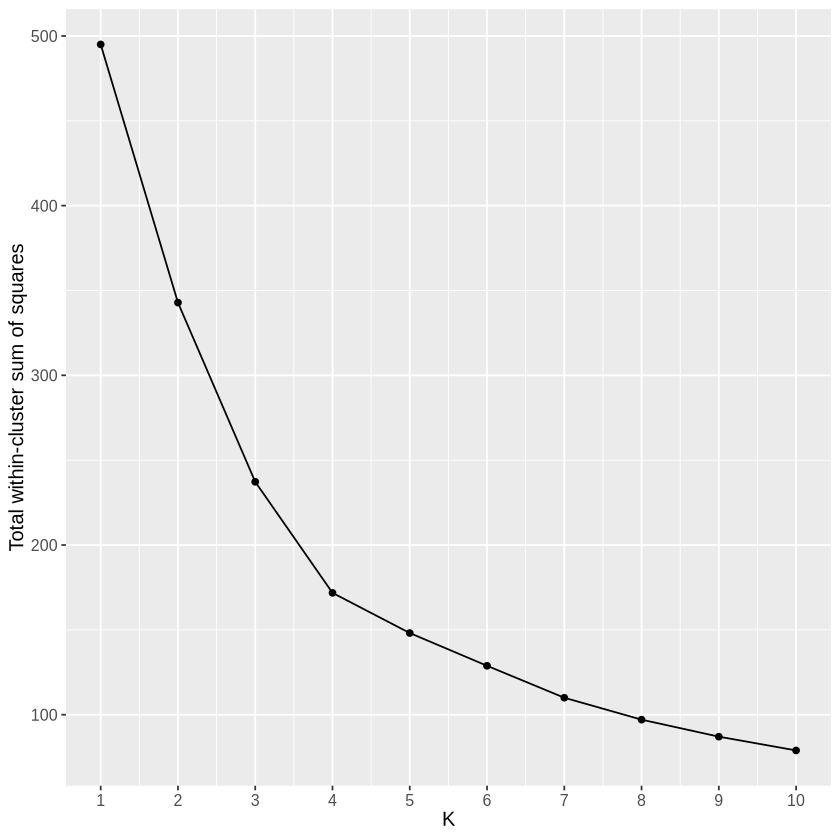

In [11]:
kmeans_results <- kmeans_results |>
    filter(.metric == "sse_within_total") |>
    mutate(total_WSSD = mean) |>
    select(num_clusters, total_WSSD)
kmeans_results

elbow_plot <- ggplot(kmeans_results, aes(x = num_clusters, y = total_WSSD)) +
  geom_point() +
  geom_line() +
  xlab("K") +
  ylab("Total within-cluster sum of squares") +
  scale_x_continuous(breaks = 1:10) +
  theme(text = element_text(size = 12))

elbow_plot


It can be seen here that the elbow is located at $K$ = 4, so this will be the amount of clusters I will use.

#### Running the model on $K$ = 4

In [12]:
kmeans_spec <- k_means(num_clusters = 4) |>
    set_engine("stats", nstart = 10)
kmeans_spec

K Means Cluster Specification (partition)

Main Arguments:
  num_clusters = 4

Engine-Specific Arguments:
  nstart = 10

Computational engine: stats 


In [13]:
set.seed(1234)

kmeans_fit <- workflow() |>
    add_recipe(kmeans_recipe) |>
    add_model(kmeans_spec) |>
    fit(data = selected_set)

kmeans_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: k_means()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-means clustering with 4 clusters of sizes 18, 56, 61, 31

Cluster means:
   frequency total_spent    recency
3 -0.8084086  -0.4563292  2.2157440
2 -0.8691676  -0.5089857 -0.2608626
4  0.7440313  -0.3179173 -0.2788380
1  0.5754462   1.8100027 -0.2666441

Clustering vector:
  [1] 1 2 3 2 3 3 2 3 2 2 3 3 2 3 2 1 4 4 2 4 2 3 3 4 4 3 2 4 3 4 3 3 3 3 2 3 3
 [38] 3 2 2 2 3 2 3 4 4 2 2 3 3 1 3 2 4 2 2 1 2 2 2 4 4 2 2 2 2 3 2 2 1 2 3 3 1
 [75] 3 2 3 3 4 2 2 1 1 4 2 3 3 4 2 2 2 3 3 1 3 3 2 4 2 3 3 2 3 4 1 3 3 2 3 2 4
[112] 4 1 4 1 3 3 3 4 1 3 3 2 2 4 3 4 3 2 3 2 3 2 3 1 2 3 1 3 2 1 3 4 3 2 4 4 2
[149] 3 3 1 4 4 4 3 2 3 2 4 2 3 3 2 2 1 4

Within cluster sum of squares by

In [14]:
clustered_data <- kmeans_fit |>
                    augment(selected_set)
clustered_data

.pred_cluster,frequency,total_spent,recency
<fct>,<dbl>,<dbl>,<dbl>
Cluster_1,14,1150,85
Cluster_2,20,1334,17
Cluster_3,22,2047,28
Cluster_2,18,1434,17
Cluster_3,22,1811,33
Cluster_3,22,1617,6
Cluster_2,20,1592,4
Cluster_3,22,1841,7
Cluster_2,19,1918,3


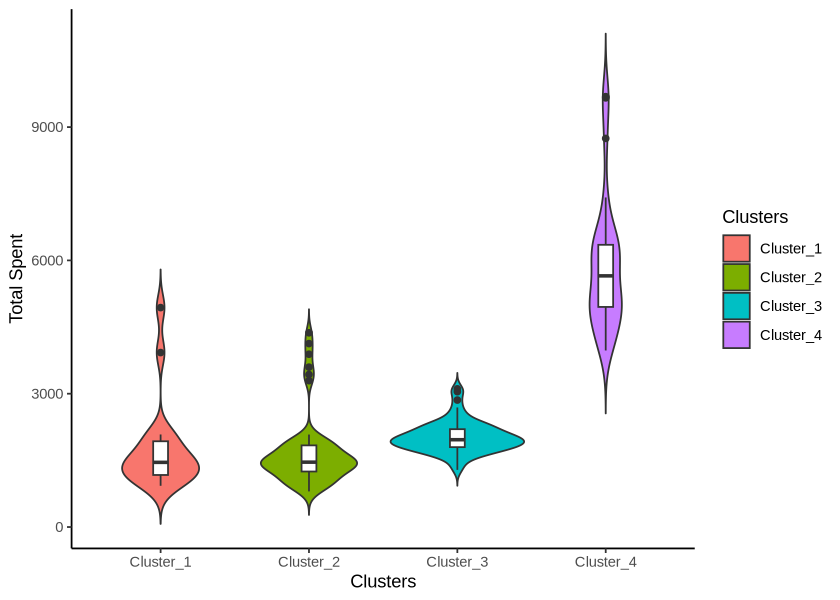

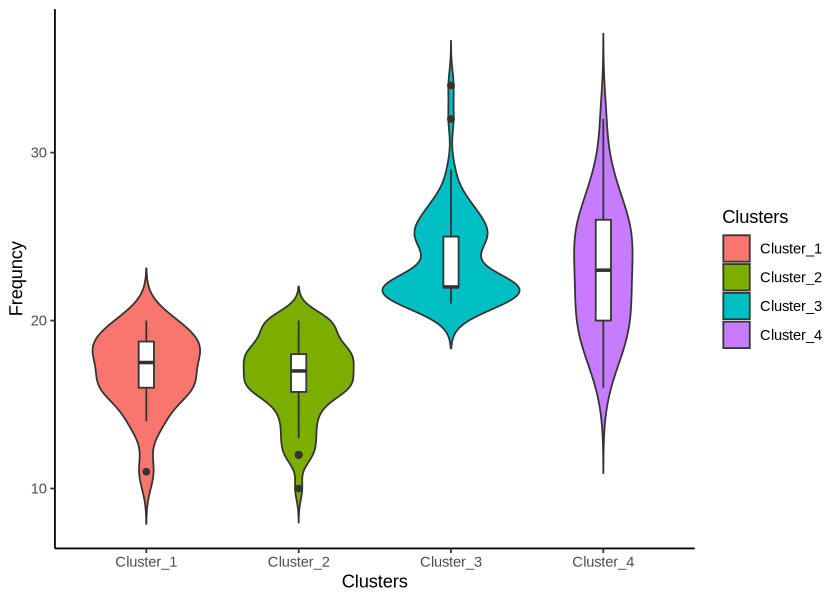

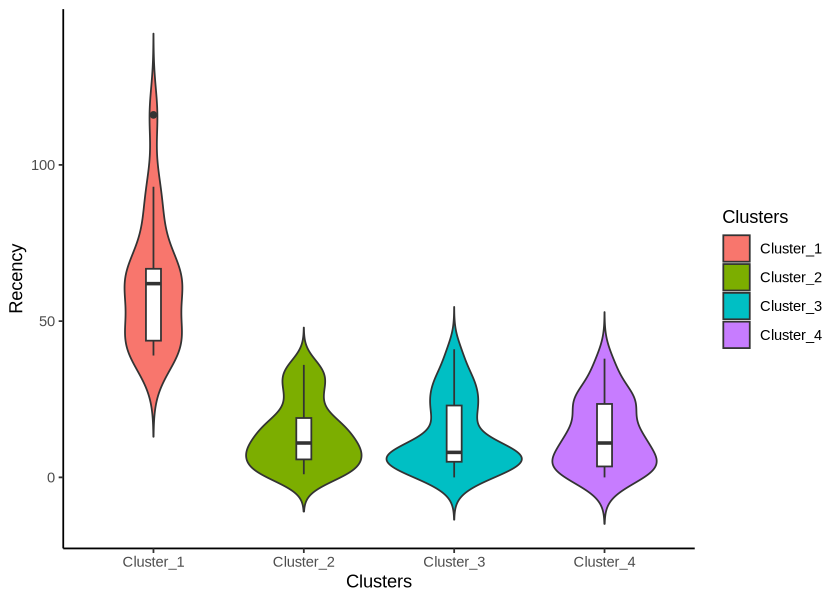

In [15]:
options(rept.plot.width = 20, repr.plot.height = 5)

violin_plot_frequency <- ggplot(clustered_data, aes(x = .pred_cluster, y = frequency, fill = .pred_cluster)) +
  geom_violin(trim=FALSE) +
  geom_boxplot(width=0.1, fill="white")+
  labs(x = "Clusters", y = "Frequncy", fill = "Clusters") +
  theme(text = element_text(size = 12)) +
  theme_classic()

violin_plot_total_spent <- ggplot(clustered_data, aes(x = .pred_cluster, y = total_spent, fill = .pred_cluster)) +
  geom_violin(trim=FALSE) +
  geom_boxplot(width=0.1, fill="white")+
  labs(x = "Clusters", y = "Total Spent", fill = "Clusters") +
  theme(text = element_text(size = 12)) +
  theme_classic()

violin_plot_recency <- ggplot(clustered_data, aes(x = .pred_cluster, y = recency, fill = .pred_cluster)) +
  geom_violin(trim=FALSE) +
  geom_boxplot(width=0.1, fill="white")+
  labs(x = "Clusters", y = "Recency", fill = "Clusters") +
  theme(text = element_text(size = 12)) +
  theme_classic()

violin_plot_total_spent
violin_plot_frequency
violin_plot_recency

Cluster 1 ~ Low Engagement:
- These individuals don't spend as much as the others in the store, and don't come as often frequently to the store, and have not came recently either.
- This customers have the least engagement in the store , so send targeted messages to remind them of the stores and offer incentives to return. Send personalized emails or SMS based on their past purchases or interests.

Cluster 2 ~ Newcomers:
- These individuals don't spend as much at the store and don't make purchases at the store frequently. Though they have been at the store recently.
- These customers can be fairly new thus the low amount spent, so it would be benneficial to offer these customers buy one get one free deals to engage them in coming more and spending more.

Cluster 3 ~ Frequent Buyers:
- These individuals don't spend as much at the store, but come frequently. They have also visited the store recently and bought something.
- These customers are consistent buyers and are loyal customers, it is best to offer these people membership opportunities or buy one get one half priced off deals, to engage them in spending more.

Cluster 4 ~ Spenders:
- The individuals spend the most in the store, shop frequently, and have visited and bought something at the store recently.
- These are the stores money makers and loyal customers, offer these customers VIP programs, or membership programs, consider adding them to an exclusive email list to attract them to certain pricier products of their intrest.